# Cancer Detection Using Convolutional Neural Network | Transfer Learning | VGG16

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL
import os
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm , classification_report as cr
import tensorflow_hub as hub

# Downloading PreTrained Vgg16 Model from keras, making all the layers freeze, and delete top layer

In [3]:
vgg16=keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3),weights='imagenet',include_top=False)

In [4]:
for layers in vgg16.layers:
  layers.trainable=False

In [5]:
x=keras.layers.Flatten()(vgg16.output)

# Adding a last layer for our dataset which is a training layer , having neurons equals to len of classes I have

In [6]:
prediction=keras.layers.Dense(4,activation='softmax')(x)

# Define a model having input layer as Vgg16 and output layer of our prediction

In [7]:
model=keras.models.Model(inputs=vgg16.input,outputs=prediction)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Developing the dataset of 3 type of cancer images and one set of normal images

In [9]:
data_url="./Dataset"
data_url

'./Dataset'

In [11]:
data_dir=pathlib.Path(data_url)
data_dir

WindowsPath('Dataset')

In [12]:
brain_image_dict={
    'AdenoCarcenoma':list(data_dir.glob("adenocarcinoma/*")),
    'LargecellCarcinoma':list(data_dir.glob("large.cell.carcinoma/*")),
    'Normal':list(data_dir.glob("normal/*")),
    'SquamousCellCarcinoma':list(data_dir.glob("squamous.cell.carcinoma/*")),
}

In [13]:
for i in brain_image_dict:
    print(len(brain_image_dict[i]))

99
88
99
99


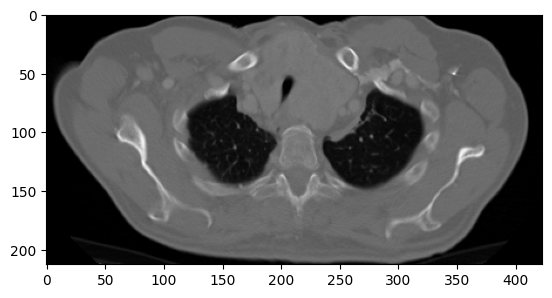

In [14]:
img=cv2.imread(str(brain_image_dict['LargecellCarcinoma'][0]))
plt.imshow(img)

In [15]:
brain_labels_dict={
    'AdenoCarcenoma':0,
    'LargecellCarcinoma':1,
    'Normal':2,
    'SquamousCellCarcinoma':3,
}

In [16]:
x=[]
y=[]
for brain_disease , images in brain_image_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        resized_image=cv2.resize(img,(224,224))
        x.append(resized_image)
        y.append(brain_labels_dict[brain_disease])

In [17]:
len(x),len(y)

(385, 385)

In [18]:
x=np.array(x)
y=np.array(y)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [20]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255

In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model.fit(x_train_scaled,y_train,epochs=5)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 1.0000 - loss: 1.4471e-05
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 1.0000 - loss: 1.4401e-05
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 944ms/step - accuracy: 1.0000 - loss: 1.8948e-05
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 936ms/step - accuracy: 1.0000 - loss: 1.6761e-05
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 1.0000 - loss: 2.3994e-05


In [27]:
model.evaluate(x_test_scaled,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - accuracy: 0.9783 - loss: 0.1170


[0.1744530200958252, 0.969072163105011]

In [28]:
prediction=[np.argmax(i) for i in model.predict(x_test_scaled)]

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step


In [29]:
prediction[:5],y_test[:5]

([2, 3, 1, 0, 2], array([2, 3, 1, 0, 2]))

In [30]:
print(cr(y_test,prediction))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00        26
           3       0.93      1.00      0.96        25

    accuracy                           0.97        97
   macro avg       0.97      0.97      0.97        97
weighted avg       0.97      0.97      0.97        97



Text(95.72222222222221, 0.5, 'Truth')

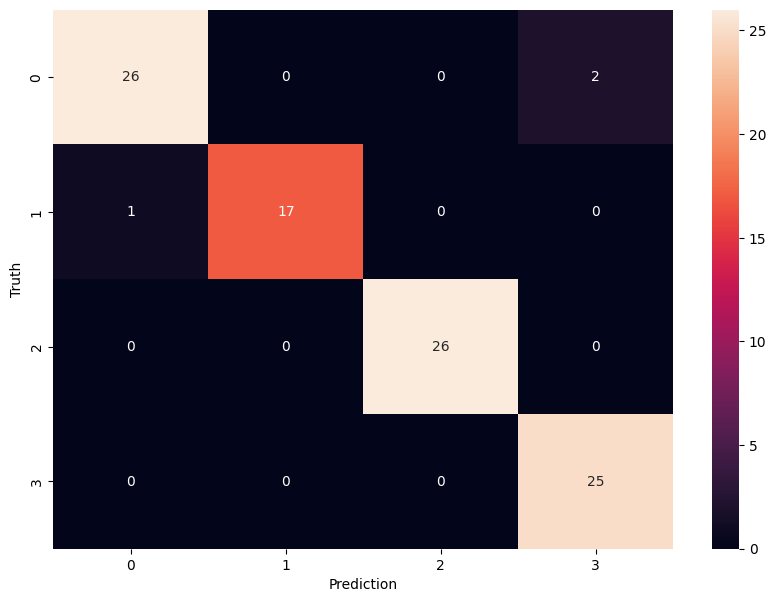

In [32]:
cmm=cm(y_test,prediction)
plt.figure(figsize=(10,7))
sb.heatmap(cmm,annot=True)
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [33]:
model.save("my_model.keras")